
# Problem 3: News Article Classification with and without NER Features

In this notebook I will:

1. **Build a baseline neural network** to classify news articles into seven categories using
   TF–IDF features of the article text.
2. **Enhance the model with Named Entity Recognition (NER) features** extracted using spaCy,
   and compare performance.

The data are provided in `news_data.csv` and contain:
- `news_headline`
- `news_article`
- `news_category` (target label)


In [9]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# For part (b)
import spacy

# Load dataset
csv_path = Path("news_data.csv")
assert csv_path.exists(), "news_data.csv not found in the current directory."

df = pd.read_csv(csv_path)
print(df.head())
print("\nShape:", df.shape)
print("\nCategories:", df['news_category'].unique())

                                       news_headline  \
0  7-foot penis-shaped wooden sculpture goes miss...   
1  Japan's Mitsubishi buys minority stake in TVS'...   
2  Jaguar Land Rover seeks US ban on Audi, other ...   
3  Facebook could soon face its 1st antitrust sui...   
4  Smith isn't that far away from Kohli: Gambhir ...   

                                        news_article news_category  
0  German police have opened an investigation int...         world  
1  Japanese automotive manufacturer Mitsubishi ha...    automobile  
2  Jaguar Land Rover (JLR) has urged the US to im...    automobile  
3  Facebook could soon face the first antitrust a...    technology  
4  Ex-India opener Gautam Gambhir has said that A...        sports  

Shape: (124, 3)

Categories: ['world' 'automobile' 'technology' 'sports' 'politics' 'entertainment'
 'science']


In [3]:
# Encode news_category into numeric labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['news_category'])

num_classes = df['label'].nunique()
print("Number of classes:", num_classes)
print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Combine headline and article into one text field
df['text'] = df['news_headline'].fillna('') + " " + df['news_article'].fillna('')

# Train-test split (80-20, random_state=42)
X = df['text'].values
y = df['label'].values

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train_text), "Test size:", len(X_test_text))

# TF-IDF vectorization
max_features = 2000  # can be tuned; trade-off between capacity and overfitting
tfidf = TfidfVectorizer(max_features=max_features, ngram_range=(1,2))

X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

print("TF-IDF train shape:", X_train_tfidf.shape)
print("TF-IDF test shape:", X_test_tfidf.shape)

# Convert labels to one-hot encoding for Keras
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Convert TF-IDF sparse matrices to dense arrays for Keras
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

Number of classes: 7
Label mapping: {'automobile': np.int64(0), 'entertainment': np.int64(1), 'politics': np.int64(2), 'science': np.int64(3), 'sports': np.int64(4), 'technology': np.int64(5), 'world': np.int64(6)}
Train size: 99 Test size: 25
TF-IDF train shape: (99, 2000)
TF-IDF test shape: (25, 2000)


In [4]:
input_dim = X_train_dense.shape[1]
print("Input dimension:", input_dim)

# Build baseline neural network
baseline_model = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

baseline_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

baseline_model.summary()

Input dimension: 2000


E:\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │         256,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 264,839 (1.01 MB)

 Trainable params: 264,839 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.2405 - loss: 1.9456 - val_accuracy: 0.1000 - val_loss: 1.9559
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3291 - loss: 1.9080 - val_accuracy: 0.1000 - val_loss: 1.9610
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4051 - loss: 1.8682 - val_accuracy: 0.1000 - val_loss: 1.9720
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4557 - loss: 1.8190 - val_accuracy: 0.1000 - val_loss: 1.9897
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4557 - loss: 1.7461 - val_accuracy: 0.1000 - val_loss: 2.0102
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5443 - loss: 1.6626 - val_accuracy: 0.1000 - val_loss: 2.0444
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5316 - loss: 1.5806 - val_accuracy: 0.1000 - val_loss: 2.0843
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5823 - loss: 1.4326 - val_accuracy: 0.1000 - v

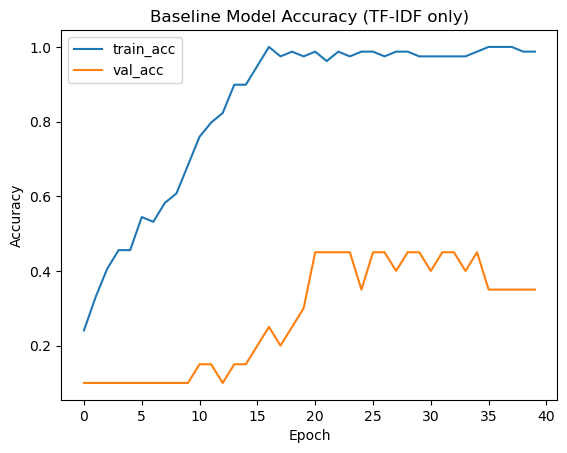

Baseline test accuracy: 0.5200


In [5]:
# Train the model with validation split
history_baseline = baseline_model.fit(
    X_train_dense, y_train_cat,
    epochs=40,
    batch_size=8,
    validation_split=0.2,
    verbose=1
)

# Plot training & validation accuracy
plt.figure()
plt.plot(history_baseline.history['accuracy'], label='train_acc')
plt.plot(history_baseline.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Baseline Model Accuracy (TF-IDF only)')
plt.legend()
plt.show()

# Evaluate on test set
test_loss, test_acc = baseline_model.evaluate(X_test_dense, y_test_cat, verbose=0)
print(f"Baseline test accuracy: {test_acc:.4f}")


## Discussion – Baseline TF–IDF Neural Network

In the write-up, report the **best test accuracy** printed above and discuss:

- How well the model performs given there are 7 classes and only 124 samples.
- Signs of **overfitting** (e.g., training accuracy >> validation accuracy).
- Possible improvements:
  - Tuning `max_features`, network size, dropout rates.
  - Trying different n-gram ranges or using pre-trained embeddings.
  - Using cross-validation rather than a single train/test split.



## Part (b) – Enhancing Classification with NER Features

Now use **spaCy** to extract named entities from the article text and convert them into
binary features. To keep the feature space small (since we only have 124 observations),
we will use **entity *types*** as features (e.g., `PERSON`, `ORG`, `GPE`, `DATE`, etc.),
rather than specific entity strings.

Each document will get a binary vector indicating whether an entity type appears in it.
These NER features will then be concatenated with the TF–IDF features and fed into a new
neural network.


In [6]:
# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Process training texts with spaCy to gather the set of entity labels
train_docs = list(nlp.pipe(X_train_text))
all_labels = sorted({ent.label_ for doc in train_docs for ent in doc.ents})
print("Entity labels found in training set:", all_labels)

label_to_idx = {lab: i for i, lab in enumerate(all_labels)}

def build_ner_type_features(docs, label_to_idx):
    # Build binary features for presence of each entity type in each doc.
    n_docs = len(docs)
    n_labels = len(label_to_idx)
    feats = np.zeros((n_docs, n_labels), dtype=np.float32)
    for i, doc in enumerate(docs):
        seen = set()
        for ent in doc.ents:
            idx = label_to_idx.get(ent.label_)
            if idx is not None:
                seen.add(idx)
        for idx in seen:
            feats[i, idx] = 1.0
    return feats

X_train_ner = build_ner_type_features(train_docs, label_to_idx)

# Process test texts with spaCy and build aligned features
test_docs = list(nlp.pipe(X_test_text))
X_test_ner = build_ner_type_features(test_docs, label_to_idx)

print("NER train features shape:", X_train_ner.shape)
print("NER test features shape:", X_test_ner.shape)

Entity labels found in training set: ['CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART']
NER train features shape: (99, 17)
NER test features shape: (25, 17)


In [7]:
# Combine TF-IDF dense features with NER binary features
X_train_combined = np.hstack([X_train_dense, X_train_ner])
X_test_combined = np.hstack([X_test_dense, X_test_ner])

print("Combined train shape:", X_train_combined.shape)
print("Combined test shape:", X_test_combined.shape)

Combined train shape: (99, 2017)
Combined test shape: (25, 2017)


Combined input dimension: 2017


E:\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 128)                 │         258,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 267,015 (1.02 MB)

 Trainable params: 267,015 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.1646 - loss: 1.9450 - val_accuracy: 0.1500 - val_loss: 1.9421
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2911 - loss: 1.9145 - val_accuracy: 0.1000 - val_loss: 1.9515
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3418 - loss: 1.8520 - val_accuracy: 0.1000 - val_loss: 1.9633
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4430 - loss: 1.7997 - val_accuracy: 0.1500 - val_loss: 1.9754
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3924 - loss: 1.7130 - val_accuracy: 0.1500 - val_loss: 1.9916
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4430 - loss: 1.6602 - val_accuracy: 0.1500 - val_loss: 2.0099
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5570 - loss: 1.5415 - val_accuracy: 0.1500 - val_loss: 2.0225
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5823 - loss: 1.4096 - val_accuracy: 0.1500 - v

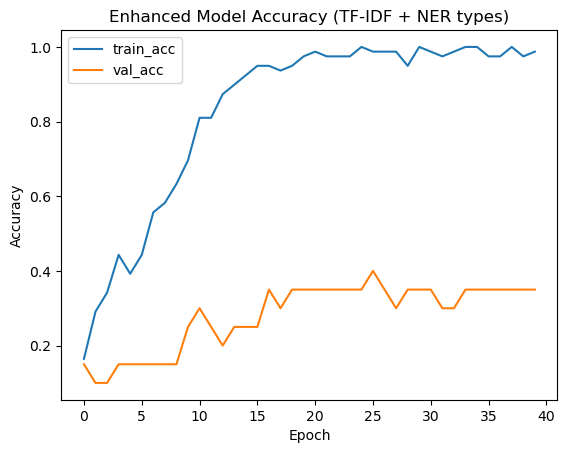

Enhanced model test accuracy: 0.5200
Random-guess accuracy (1/7): 0.1429


In [8]:
input_dim_combined = X_train_combined.shape[1]
print("Combined input dimension:", input_dim_combined)

enhanced_model = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim_combined,)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

enhanced_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

enhanced_model.summary()

history_enhanced = enhanced_model.fit(
    X_train_combined, y_train_cat,
    epochs=40,
    batch_size=8,
    validation_split=0.2,
    verbose=1
)

# Plot training & validation accuracy
plt.figure()
plt.plot(history_enhanced.history['accuracy'], label='train_acc')
plt.plot(history_enhanced.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Enhanced Model Accuracy (TF-IDF + NER types)')
plt.legend()
plt.show()

# Evaluate on test set
test_loss_enh, test_acc_enh = enhanced_model.evaluate(X_test_combined, y_test_cat, verbose=0)
print(f"Enhanced model test accuracy: {test_acc_enh:.4f}")

# Random-guess accuracy for balanced classes
random_guess_acc = 1.0 / num_classes
print(f"Random-guess accuracy (1/{num_classes}): {random_guess_acc:.4f}")


## Discussion – Effect of NER Features

In your report, address the following:

- **Comparison of accuracies**  
  - Baseline TF–IDF model test accuracy vs. enhanced TF–IDF + NER model accuracy.  
  - How do both compare to the random-guess baseline of ~0.14 (1/7)?

- **Impact of NER features**  
  - Did including entity-type features improve performance?  
  - Why might entity information help distinguish categories (e.g., presence of certain
    organizations, locations, or dates)?

- **Limitations and further experiments**  
  - The dataset is very small (124 articles), so results may be unstable.  
  - Possible extensions:
    - Use specific named entities instead of entity types (binary features per entity string).
    - Try different neural architectures or regularization settings.
    - Use pre-trained language models (e.g., BERT) for text embeddings.
